### 介绍 \ Introduction

这一节主要介绍如何使用FLGo来实现自己的idea。这里首先关注的是本地训练阶段有所变化的算法（如FedProx，MOON等），这类算法在联邦学习中是极为常见的，因为联邦学习中用户数据分布通常是non-IID的，导致本地训练容易越走越偏。下面从FedProx入手，讲解如何使用FLGo复现该算法。

### FedProx简介 

FedProx是Li Tian等人于2018年([论文链接](https://arxiv.org/abs/1812.06127))所提出的一种针对系统异构性鲁棒的联邦优化算法，发表于MLSys 2020上。它相较于FedAvg主要做出了两点改进：

1. 采样阶段
使用了按数据集大小比例，可放回采样，并直接平均聚合（无加权）来获得无偏梯度估计

2. 本地训练阶段
基于近端项优化的思路，魔改了本地训练的目标函数为 $L+\frac{\mu}{2}\|w_{k,i}^{t}-w_{global}\|_{2}$

由于该采样方式已被FLGo集成并默认使用，要实现FedProx只需要修改本地训练阶段的代码


### 加入算法超参数
所有的横向联邦中的超参数都在Server的initialize方法中加入，加入的方法是调用Server.init_algo_para方法，并传入超参数字典。例如，对于fedprox来说，超参数是mu，因此只要通过该方法传入{'mu':0.01}，Server和Client就会被添加额外的属性Server.mu和Client.mu来访问该超参数，其中0.01是默认值。

In [1]:
import flgo.algorithm.fedbase as fedbase
import flgo.algorithm.fedavg as fedavg
import flgo.utils.fmodule as fmodule
import os
import flgo
import copy
import torch

class Server(fedbase.BasicServer):
    def initialize(self, *args, **kwargs):
        self.init_algo_para({'mu':0.01})

### 修改本地训练阶段

In [2]:
class Client(fedbase.BasicClient):
    @fmodule.with_multi_gpus
    def train(self, model):
        # 记录全局模型参数\global parameters
        src_model = copy.deepcopy(model)
        # 冻结全局模型梯度
        src_model.freeze_grad()
        model.train()
        optimizer = self.calculator.get_optimizer(model, lr=self.learning_rate, weight_decay=self.weight_decay, momentum=self.momentum)
        for iter in range(self.num_steps):
            # get a batch of data
            batch_data = self.get_batch_data()
            model.zero_grad()
            # calculate the loss of the model on batched dataset through task-specified calculator
            loss = self.calculator.compute_loss(model, batch_data)['loss']
            # 计算近端项损失
            loss_proximal = 0
            for pm, ps in zip(model.parameters(), src_model.parameters()):
                loss_proximal += torch.sum(torch.pow(pm - ps, 2))
            loss = loss + 0.5 * self.mu * loss_proximal
            loss.backward()
            optimizer.step()
        return

### 构造算法fedprox
在FLGo中，每个算法既可以用一个类表示，也可以用一个文件表示，唯一的要求是算法必须具备 algorithm_name.Server和algorithm_name.Client这两个属性（对于横向联邦是这俩）。

In [3]:
class fedprox:
    Server = Server
    Client = Client

### 测试fedprox

2023-03-14 15:12:16,006 fflow.py init [line:347] INFO Initializing devices: cuda:0 will be used for this running.
2023-03-14 15:12:19,071 fflow.py init [line:389] INFO Use `<class 'flgo.simulator.default_simulator.Simulator'>` as the system simulator
2023-03-14 15:12:19,072 fflow.py init [line:397] INFO Ready to start.
2023-03-14 15:12:19,079 fflow.py init [line:347] INFO Initializing devices: cuda:0 will be used for this running.
2023-03-14 15:12:19,263 fflow.py init [line:389] INFO Use `<class 'flgo.simulator.default_simulator.Simulator'>` as the system simulator
2023-03-14 15:12:19,263 fflow.py init [line:397] INFO Ready to start.
2023-03-14 15:12:19,269 fedbase.py run [line:104] INFO --------------Initial Evaluation--------------
2023-03-14 15:12:19,270 simple_logger.py log_once [line:13] INFO Current_time:0
2023-03-14 15:12:19,983 simple_logger.py log_once [line:27] INFO test_accuracy                 0.0489
2023-03-14 15:12:19,983 simple_logger.py log_once [line:27] INFO test_loss

2023-03-14 15:12:21,396 simple_logger.py log_once [line:27] INFO std_val_accuracy            0.3625
2023-03-14 15:12:21,397 simple_logger.py log_once [line:27] INFO val_loss                    1.6722
2023-03-14 15:12:21,397 simple_logger.py log_once [line:27] INFO mean_val_loss               1.6722
2023-03-14 15:12:21,397 simple_logger.py log_once [line:27] INFO std_val_loss                0.6872
2023-03-14 15:12:21,398 fedbase.py run [line:121] INFO Eval Time Cost:               0.0436s
2023-03-14 15:12:21,607 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2096s
2023-03-14 15:12:21,608 fedbase.py run [line:116] INFO --------------Round 7--------------
2023-03-14 15:12:21,608 simple_logger.py log_once [line:13] INFO Current_time:7
2023-03-14 15:12:21,649 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4311
2023-03-14 15:12:21,649 simple_logger.py log_once [line:27] INFO test_loss                     1.6956
2023-03-14 15:12:21,650 simple_logger.p

2023-03-14 15:12:23,034 simple_logger.py log_once [line:27] INFO std_val_accuracy            0.3740
2023-03-14 15:12:23,034 simple_logger.py log_once [line:27] INFO val_loss                    1.2970
2023-03-14 15:12:23,034 simple_logger.py log_once [line:27] INFO mean_val_loss               1.2970
2023-03-14 15:12:23,035 simple_logger.py log_once [line:27] INFO std_val_loss                0.7761
2023-03-14 15:12:23,035 fedbase.py run [line:121] INFO Eval Time Cost:               0.0436s
2023-03-14 15:12:23,177 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1413s
2023-03-14 15:12:23,177 fedbase.py run [line:116] INFO --------------Round 14--------------
2023-03-14 15:12:23,177 simple_logger.py log_once [line:13] INFO Current_time:14
2023-03-14 15:12:23,219 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5583
2023-03-14 15:12:23,219 simple_logger.py log_once [line:27] INFO test_loss                     1.2830
2023-03-14 15:12:23,219 simple_logger

2023-03-14 15:12:24,520 simple_logger.py log_once [line:27] INFO std_val_accuracy            0.3731
2023-03-14 15:12:24,520 simple_logger.py log_once [line:27] INFO val_loss                    1.0550
2023-03-14 15:12:24,520 simple_logger.py log_once [line:27] INFO mean_val_loss               1.0550
2023-03-14 15:12:24,521 simple_logger.py log_once [line:27] INFO std_val_loss                0.7710
2023-03-14 15:12:24,521 fedbase.py run [line:121] INFO Eval Time Cost:               0.0428s
2023-03-14 15:12:24,723 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2019s
2023-03-14 15:12:24,724 fedbase.py run [line:116] INFO --------------Round 21--------------
2023-03-14 15:12:24,724 simple_logger.py log_once [line:13] INFO Current_time:21
2023-03-14 15:12:24,766 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6367
2023-03-14 15:12:24,766 simple_logger.py log_once [line:27] INFO test_loss                     1.0751
2023-03-14 15:12:24,767 simple_logger

2023-03-14 15:12:26,087 simple_logger.py log_once [line:27] INFO std_val_accuracy            0.3624
2023-03-14 15:12:26,087 simple_logger.py log_once [line:27] INFO val_loss                    0.9753
2023-03-14 15:12:26,088 simple_logger.py log_once [line:27] INFO mean_val_loss               0.9753
2023-03-14 15:12:26,088 simple_logger.py log_once [line:27] INFO std_val_loss                0.7841
2023-03-14 15:12:26,088 fedbase.py run [line:121] INFO Eval Time Cost:               0.0416s
2023-03-14 15:12:26,252 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1638s
2023-03-14 15:12:26,253 fedbase.py run [line:116] INFO --------------Round 28--------------
2023-03-14 15:12:26,253 simple_logger.py log_once [line:13] INFO Current_time:28
2023-03-14 15:12:26,295 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6578
2023-03-14 15:12:26,296 simple_logger.py log_once [line:27] INFO test_loss                     0.9871
2023-03-14 15:12:26,296 simple_logger

2023-03-14 15:12:27,759 simple_logger.py log_once [line:27] INFO mean_val_accuracy           0.2735
2023-03-14 15:12:27,759 simple_logger.py log_once [line:27] INFO std_val_accuracy            0.3490
2023-03-14 15:12:27,759 simple_logger.py log_once [line:27] INFO val_loss                    2.0618
2023-03-14 15:12:27,759 simple_logger.py log_once [line:27] INFO mean_val_loss               2.0618
2023-03-14 15:12:27,760 simple_logger.py log_once [line:27] INFO std_val_loss                0.6546
2023-03-14 15:12:27,760 fedbase.py run [line:121] INFO Eval Time Cost:               0.0443s
2023-03-14 15:12:28,008 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2475s
2023-03-14 15:12:28,008 fedbase.py run [line:116] INFO --------------Round 4--------------
2023-03-14 15:12:28,008 simple_logger.py log_once [line:13] INFO Current_time:4
2023-03-14 15:12:28,047 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3767
2023-03-14 15:12:28,048 simple_logger.py 

2023-03-14 15:12:30,053 simple_logger.py log_once [line:27] INFO mean_val_accuracy           0.5000
2023-03-14 15:12:30,053 simple_logger.py log_once [line:27] INFO std_val_accuracy            0.4026
2023-03-14 15:12:30,053 simple_logger.py log_once [line:27] INFO val_loss                    1.5096
2023-03-14 15:12:30,054 simple_logger.py log_once [line:27] INFO mean_val_loss               1.5096
2023-03-14 15:12:30,054 simple_logger.py log_once [line:27] INFO std_val_loss                0.8912
2023-03-14 15:12:30,054 fedbase.py run [line:121] INFO Eval Time Cost:               0.0504s
2023-03-14 15:12:30,361 fedbase.py run [line:113] INFO Iterate Time Cost:            0.3062s
2023-03-14 15:12:30,361 fedbase.py run [line:116] INFO --------------Round 11--------------
2023-03-14 15:12:30,362 simple_logger.py log_once [line:13] INFO Current_time:11
2023-03-14 15:12:30,402 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5256
2023-03-14 15:12:30,403 simple_logger.p

2023-03-14 15:12:32,282 simple_logger.py log_once [line:27] INFO mean_val_accuracy           0.6951
2023-03-14 15:12:32,282 simple_logger.py log_once [line:27] INFO std_val_accuracy            0.3205
2023-03-14 15:12:32,282 simple_logger.py log_once [line:27] INFO val_loss                    1.0853
2023-03-14 15:12:32,283 simple_logger.py log_once [line:27] INFO mean_val_loss               1.0853
2023-03-14 15:12:32,283 simple_logger.py log_once [line:27] INFO std_val_loss                0.7537
2023-03-14 15:12:32,283 fedbase.py run [line:121] INFO Eval Time Cost:               0.0409s
2023-03-14 15:12:32,560 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2765s
2023-03-14 15:12:32,560 fedbase.py run [line:116] INFO --------------Round 18--------------
2023-03-14 15:12:32,561 simple_logger.py log_once [line:13] INFO Current_time:18
2023-03-14 15:12:32,594 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6633
2023-03-14 15:12:32,594 simple_logger.p

2023-03-14 15:12:34,401 simple_logger.py log_once [line:27] INFO mean_val_accuracy           0.7539
2023-03-14 15:12:34,401 simple_logger.py log_once [line:27] INFO std_val_accuracy            0.3064
2023-03-14 15:12:34,401 simple_logger.py log_once [line:27] INFO val_loss                    0.8600
2023-03-14 15:12:34,402 simple_logger.py log_once [line:27] INFO mean_val_loss               0.8600
2023-03-14 15:12:34,402 simple_logger.py log_once [line:27] INFO std_val_loss                0.6646
2023-03-14 15:12:34,402 fedbase.py run [line:121] INFO Eval Time Cost:               0.0418s
2023-03-14 15:12:34,680 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2774s
2023-03-14 15:12:34,680 fedbase.py run [line:116] INFO --------------Round 25--------------
2023-03-14 15:12:34,680 simple_logger.py log_once [line:13] INFO Current_time:25
2023-03-14 15:12:34,717 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7406
2023-03-14 15:12:34,718 simple_logger.p

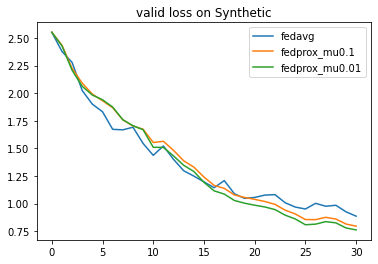

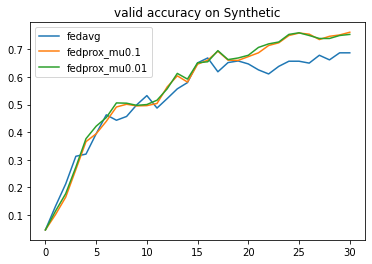

In [4]:
task = './test_synthetic'
config = {'benchmark':{'name':'flgo.benchmark.synthetic_regression', 'para':{'alpha':0.5, 'beta':0.5, 'num_clients':30}}}
if not os.path.exists(task): flgo.gen_task(config, task_path = task)
option = {'num_rounds':30, 'num_epochs':1, 'batch_size':8, 'learning_rate':0.1, 'gpu':0}
fedavg_runner = flgo.init(task, fedavg, option=option)
fedprox_runner = flgo.init(task, fedprox, option=option)
fedavg_runner.run()
fedprox_runner.run()
import flgo.experiment.analyzer
analysis_plan = {
    'Selector':{
        'task': task,
        'header':['fedavg', 'fedprox']
    },
    'Painter':{
        'Curve':[
            {'args':{'x': 'communication_round', 'y':'val_loss'}, 'fig_option':{'title':'valid loss on Synthetic'}},
            {'args':{'x': 'communication_round', 'y':'val_accuracy'},  'fig_option':{'title':'valid accuracy on Synthetic'}},
        ]
    }
}
flgo.experiment.analyzer.show(analysis_plan)